# **Predicting Red Cards within a Shuffled Deck**

Our aim is to play a card-game in which the cards are iteratively flipped until we tell the dealer to stop. Afterwards, one additional card is flipped. If that card is flipped. If that card is red, we win a dollar. Otherwise, we lose a dollar.

We'll start by creating a deck holding 26 red cards and 26 black cards. Black cards are represented by zeroes and red cards are represented by ones.

In [50]:
import numpy as np 
import matplotlib.pyplot as plt 
import itertools

### **Modeling a 52-card deck**

In [36]:
red_cards = 26 * [1]
black_cards = 26 * [0]
unshuffled_deck = red_cards + black_cards

We'll proceed to shuffle the deck.

### **Shuffling a 52-card deck**

In [37]:
np.random.seed(24)
shuffled_deck = np.random.permutation(unshuffled_deck)

Now we'll iteratively flip over the cards within the deck, stopping when the number of red cards remanining in the deck.

### **Coding a card-game strategy**

In [38]:
remaining_red_cards = 26 
for i, card in enumerate(shuffled_deck[:-1]):
    remaining_red_cards -= card 
    remaining_total_cards = 52 - i - 1
    if remaining_red_cards / remaining_total_cards > 0.5:
        break
        
print(f"Stopping the game at index {i}.")
final_card = shuffled_deck[i + 1]
color = 'red' if final_card else 0
print(f"The next card in the deck is {'red' if final_card else 'black'}.")
print(f"We have {'won' if final_card else 'lost'}!")

Stopping the game at index 24.
The next card in the deck is red.
We have won!


The strategy yielded a win on our very first try. Let's generalize this strategy to halt when the fraction of remaining red cards is greater than an imputed min_red_fraction parameter.

### **Generalizing the card-game strategy** 

In [39]:
total_cards = 52
total_red_cards = 26
def execute_strategy(min_fraction_red = 0.5, shuffled_deck = None, return_index = False):
    if shuffled_deck is None:
        shuffled_deck = np.random.permutation(unshuffled_deck)

    remaining_red_cards = total_red_cards 

    for i, card in enumerate(shuffled_deck[:-1]):
        remaining_red_cards -= card
        fraction_red_cards = remaining_red_cards / (total_cards - i -1)
        if fraction_red_cards > min_fraction_red:
            break 

    return (i + 1, shuffled_deck[ i + 1 ]) if return_index else shuffled_deck[i + 1]

## **Estimating the Probability of Strategy Success**

Applying basic strategy to a series of 1000 random shuffles

### **Running strategy over 1000 shuffles**

In [40]:
np.random.seed(0)
observations = np.array([execute_strategy() for _ in range(1000)])

The total fraction of ones in observations corresponds to the observed fraction of red cards, and therefore to the fraction of wins. We can compute this fraction by calling observations.mean().

### **Computing the frequency of wins**

In [41]:
frequency_wins = observations.sum() / 1000
assert frequency_wins == observations.mean()
print(f"The frequency of wins is {frequency_wins}")

The frequency of wins is 0.511


We've won 51.1 percent of total games! Our strategy appears to be working. 524 wins and 76 losses will net us a total profit of $22.

### **Computing total profit**

In [42]:
dollars_won = frequency_wins * 1000
dollars_lost = (1 - frequency_wins) * 1000
total_profit = dollars_won - dollars_lost 
print(f"Total profit is ${total_profit}")

Total profit is $22.0


The strategy worked well for a sample size of 1000 shuffles. We'll now plot the strategy's win-frequency convergence over a series of sample sizes ranging from 1 to 10,000.

### **Plotting simulated frequencies of wins**

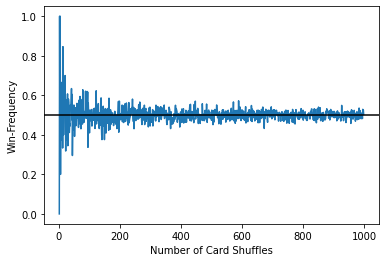

The win-frequency for 10,000 shuffles is 0.5035035035035035


In [43]:
np.random.seed(0)
def repeat_game(number_repeats):
    observations = np.array([execute_strategy()
                             for _ in range(number_repeats)]) 
    return observations.mean()

frequencies = [] 
for i in range(1, 1000):
    frequencies.append(repeat_game(i))

plt.plot(list(range(1, 1000)), frequencies)
plt.axhline(0.5, color = 'k')
plt.xlabel('Number of Card Shuffles')
plt.ylabel('Win-Frequency')
plt.show();
print(f"The win-frequency for 10,000 shuffles is {frequencies[-1]}")

Our strategy fluctuates above and below 50% through-out the entire sampling process. We'll need to compute a confidence interval to ensure that its win-rate is above 50%. We'll compute the confidence interval by sampling 10,000 card-shuffles 300 times. Shuffling an array is a computationally expensive procedure. 

In [44]:
def compute_high_confidence_interval(likelihoods, bin_width):
    peak_index = likelihoods.argmax()
    area = likelihoods[peak_index] * bin_width
    start_index, end_index = peak_index, peak_index + 1
    while area < 0.95:
        if start_index > 0:
            start_index -= 1
        if end_index < likelihoods.size - 1:
            end_index += 1
        area = likelihoods[start_index: end_index + 1].sum() * bin_width
    range_start, range_end = bin_edges[start_index], bin_edges[end_index]
    range_string = f"{range_start:.6f} - {range_end:.6f}"
    print((f"The frequency range {range_string} represents a "
    f"{100 * area:.2f}% confidence interval"))
    return start_index, end_index

The frequency range 0.488938 - 0.509494 represents a 97.00% confidence interval


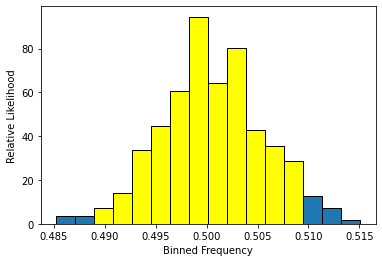

In [45]:
np.random.seed(0)
frequency_array = np.array([repeat_game(10000) for _ in range(300)])

likelihoods, bin_edges, patches = plt.hist(frequency_array, bins = 'auto',
                                           edgecolor = 'black', density = True) 
bin_width = bin_edges[1] - bin_edges[0]
start_index, end_index = compute_high_confidence_interval(likelihoods, bin_width)

for i in range(start_index, end_index):
    patches[i].set_facecolor('yellow')
plt.xlabel('Binned Frequency')
plt.ylabel('Relative Likelihood')
plt.show();

We can narrow the confidence interval by increasing the sample size, at the expense of running time. The code below will sample 50,000 shuffles over 3,000 iterations.

### **Computing the confidence interval for 150 million shuffles**

In [46]:
np.random.seed(0)

frequency_array = np.array([repeat_game(50000) for _ in range(3000)])
likelihoods, bin_edges = np.histogram(frequency_array, bins='auto',
                                      density=True)
bin_width = bin_edges[1] - bin_edges[0]
compute_high_confidence_interval(likelihoods, bin_width)

The frequency range 0.495601 - 0.504345 represents a 96.03% confidence interval


(11, 32)

We can also min_red_fraction from 0.5 to 0.75 and repeat the confidence interval calculation process.

### **Computing the confidence interval for an updated strategy**

In [55]:
def get_matching_event(event_condition, sample_space):
    return set([outcome for outcome in sample_space
                if event_condition(outcome)])

In [56]:
def compute_event_probability(event_condition, generic_sample_space):
    event = get_matching_event(event_condition, generic_sample_space)
    if type(generic_sample_space) == type(set()):
        return len(event) / len(generic_sample_space)
    event_size = sum(generic_sample_space[outcome]
                    for outcome in event)
    return event_size / sum(generic_sample_space.values())

In [57]:
total_cards = 10
total_red_cards = int(total_cards / 2)
total_black_cards = total_red_cards
unshuffled_deck = [1] * total_red_cards + [0] * total_black_cards
sample_space = set(itertools.permutations(unshuffled_deck))
win_condition = lambda x: execute_strategy(shuffled_deck=np.array(x)) 
prob_win = compute_event_probability(win_condition, sample_space)
print(f"Probability of a win is {prob_win}")

Probability of a win is 0.5


In [58]:
def scan_strategies():
    fractions = [value / 100 for value in range(50, 100)]
    probabilities = []
    for frac in fractions:
        win_condition = lambda x: execute_strategy(frac,
                                                   shuffled_deck=np.array(x))
        probabilities.append(compute_event_probability(win_condition,
                                                       sample_space))
    return probabilities

probabilities = scan_strategies()
print(f"Lowest probability of win is {min(probabilities)}")
print(f"Highest probability of win is {max(probabilities)}")

Lowest probability of win is 0.5
Highest probability of win is 0.5


In [59]:
for total_cards in [2, 4, 6, 8]:
    total_red_cards = int(total_cards / 2)
    total_black_cards = total_red_cards
    unshuffled_deck = [1] * total_red_cards + [0] * total_black_cards

    sample_space = set(itertools.permutations(unshuffled_deck))
    probabilities = scan_strategies()
    if all(prob == 0.5 for prob in probabilities):
        print(f"No winning strategy found for deck of size {total_cards}")
    else:
        print(f"Winning strategy found for deck of size {total_cards}")

No winning strategy found for deck of size 2
No winning strategy found for deck of size 4
No winning strategy found for deck of size 6
No winning strategy found for deck of size 8


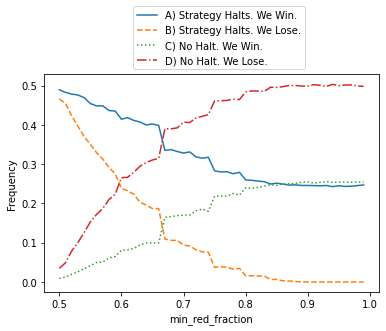

In [60]:
np.random.seed(0)
total_cards = 52
total_red_cards = 26
unshuffled_deck = red_cards + black_cards

def repeat_game_detailed(number_repeats, min_red_fraction):

    observations = [execute_strategy(min_red_fraction, return_index=True)
                    for _ in range(num_repeats)] 
    successes = [index for index, card, in observations if card == 1] 
    halt_success = len([index for index in successes if index != 51]) 
    no_halt_success = len(successes) - halt_success 

    failures = [index for index, card, in observations if card == 0] 
    halt_failure = len([index for index in failures if index != 51]) 
    no_halt_failure = len(failures) - halt_failure 
    result = [halt_success, halt_failure, no_halt_success, no_halt_failure]
    return [r / number_repeats for r in result] 

fractions = [value / 100 for value in range(50, 100)]
num_repeats = 50000
result_types = [[], [], [], []]

for fraction in fractions: 
    result = repeat_game_detailed(num_repeats, fraction)
    for i in range(4):
        result_types[i].append(result[i])

plt.plot(fractions, result_types[0],
         label='A) Strategy Halts. We Win.')
plt.plot(fractions, result_types[1], linestyle='--',
         label='B) Strategy Halts. We Lose.')
plt.plot(fractions, result_types[2], linestyle=':',
         label='C) No Halt. We Win.')
plt.plot(fractions, result_types[3], linestyle='-.',
         label='D) No Halt. We Lose.')
plt.xlabel('min_red_fraction')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(0.25, 1.0))
plt.show()

In [61]:
def optimal_strategy(shuffled_deck):
    return shuffled_deck[0]